In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv("dataset.csv")

In [65]:
df = df.map(lambda x: x.strip("'") if isinstance(x, str) else x)

df.drop(['zipcodeOri', 'zipMerchant'], axis=1, inplace=True)

In [66]:
df.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,11,C1760492708,1,F,M1823072687,es_transportation,52.35,0
1,172,C1222389110,3,M,M1823072687,es_transportation,14.75,0
2,106,C879949041,3,F,M1823072687,es_transportation,3.73,0
3,86,C409740988,5,M,M1823072687,es_transportation,61.42,0
4,152,C671449181,3,F,M692898500,es_health,9.05,0


In [67]:

# Encode categorical
le = LabelEncoder()
for col in ['customer', 'age', 'gender', 'merchant', 'category']:
    df[col] = le.fit_transform(df[col])

# Split
X = df.drop("fraud", axis=1)
y = df["fraud"]

# Scale numerical 
scaler = StandardScaler()
X[['step', 'amount']] = scaler.fit_transform(X[['step', 'amount']])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

Accuracy: 0.9945139952913039
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    132172
           1       0.88      0.64      0.74      1623

    accuracy                           0.99    133795
   macro avg       0.94      0.82      0.87    133795
weighted avg       0.99      0.99      0.99    133795



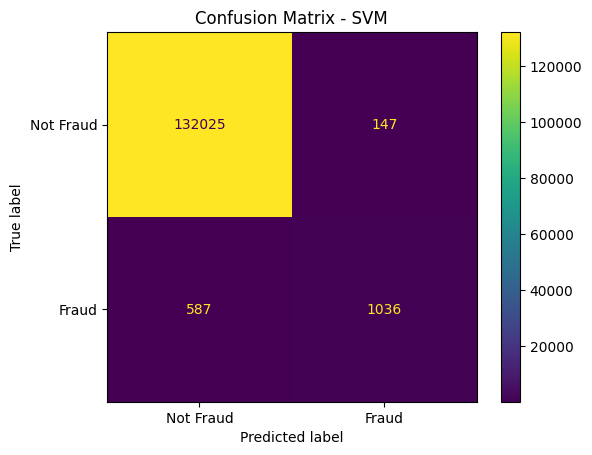

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)


mlp_model.fit(X_train, y_train)
y_proba = mlp_model.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
    
# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Not Fraud", "Fraud"])
plt.title(f"Confusion Matrix - {name}")
plt.show()


In [72]:
joblib.dump(mlp_model, 'mlp_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [29]:
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score
import joblib

model = lgb.LGBMClassifier(scale_pos_weight=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

joblib.dump(model, "models/lightgbm_model.pkl")

[LightGBM] [Info] Number of positive: 4869, number of negative: 396514
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 766
[LightGBM] [Info] Number of data points in the train set: 401383, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012131 -> initscore=-4.399823
[LightGBM] [Info] Start training from score -4.399823
Precision: 0.5885601577909271
Recall: 0.9192852741836106


['models/lightgbm_model.pkl']

In [73]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.models import load_model

input_dim = X_train.shape[1]
inp = Input(shape=(input_dim,))
e1 = Dense(14, activation="relu")(inp)
e2 = Dense(7, activation="relu")(e1)
d1 = Dense(14, activation="relu")(e2)
out = Dense(input_dim, activation="linear")(d1)

autoencoder = Model(inputs=inp, outputs=out)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(X_train[y_train==0], X_train[y_train==0], epochs=5, batch_size=64)

autoencoder.save("models/autoencoder_model.h5")



Epoch 1/5
6196/6196 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 121009.2656
Epoch 2/5
6196/6196 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.6670
Epoch 3/5
6196/6196 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.9808
Epoch 4/5
6196/6196 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.5935
Epoch 5/5
6196/6196 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.4006


In [74]:
from keras.models import Model
from sklearn.preprocessing import StandardScaler
import joblib

# Extract encoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=1).output)

# Fit scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

# Save both
joblib.dump(encoder, 'models/encoder.pkl')
joblib.dump(scaler, 'models/scaler.pkl')

print("Saved encoder.pkl and scaler.pkl successfully.")


Saved encoder.pkl and scaler.pkl successfully.


In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)

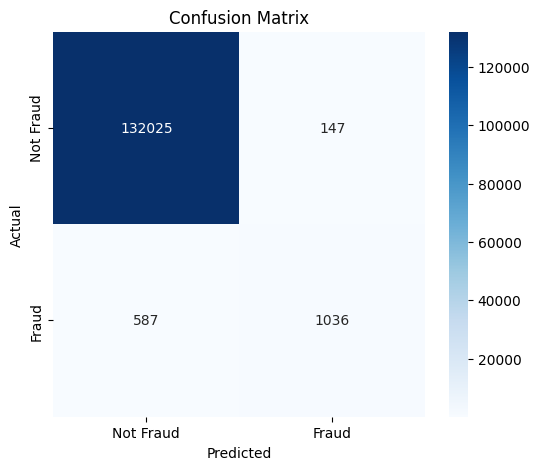

In [76]:
y_pred = mlp_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [77]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Fraud", "Fraud"]))


Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    132172
       Fraud       0.88      0.64      0.74      1623

    accuracy                           0.99    133795
   macro avg       0.94      0.82      0.87    133795
weighted avg       0.99      0.99      0.99    133795



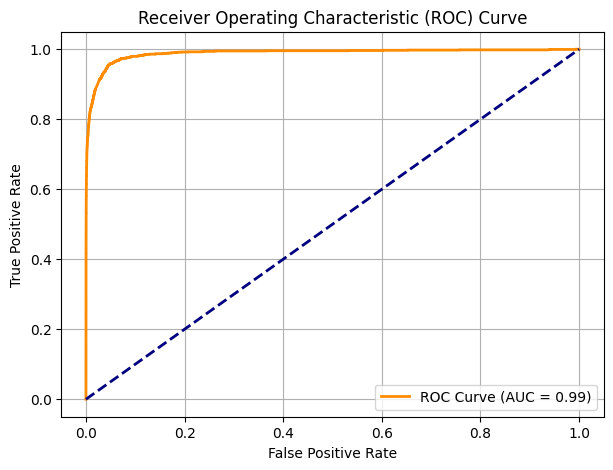

In [78]:
# Predict probabilities for ROC curve
y_prob = mlp_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


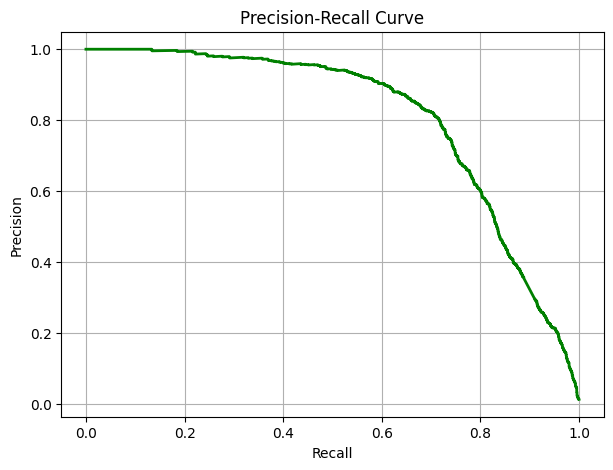

In [79]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, color="green", lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()

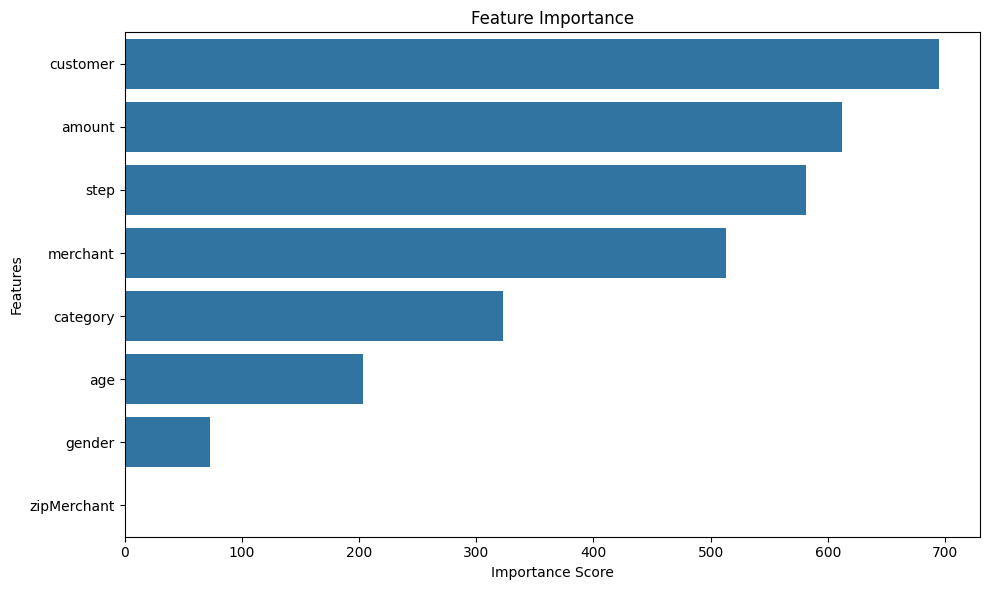

In [37]:
if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    feature_names = X.columns  # Replace X with your feature DataFrame

    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feat_imp, y=feat_imp.index)
    plt.title("Feature Importance")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()


In [93]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt

# Predict probabilities and classes
y_proba = mlp_model.predict_proba(X_test)[:, 1]  # probability of class 1 (fraud)
y_pred = (y_proba > 0.3).astype(int)  # use your threshold

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

# Print metrics
print(f" Accuracy       : {accuracy:.4f}")
print(f" Precision      : {precision:.4f}")
print(f" Recall         : {recall:.4f}")
print(f" F1 Score       : {f1:.4f}")
print(f" AUC-ROC Score  : {auc:.4f}")



 Accuracy       : 0.9944
 Precision      : 0.8014
 Recall         : 0.7160
 F1 Score       : 0.7563
 AUC-ROC Score  : 0.9885


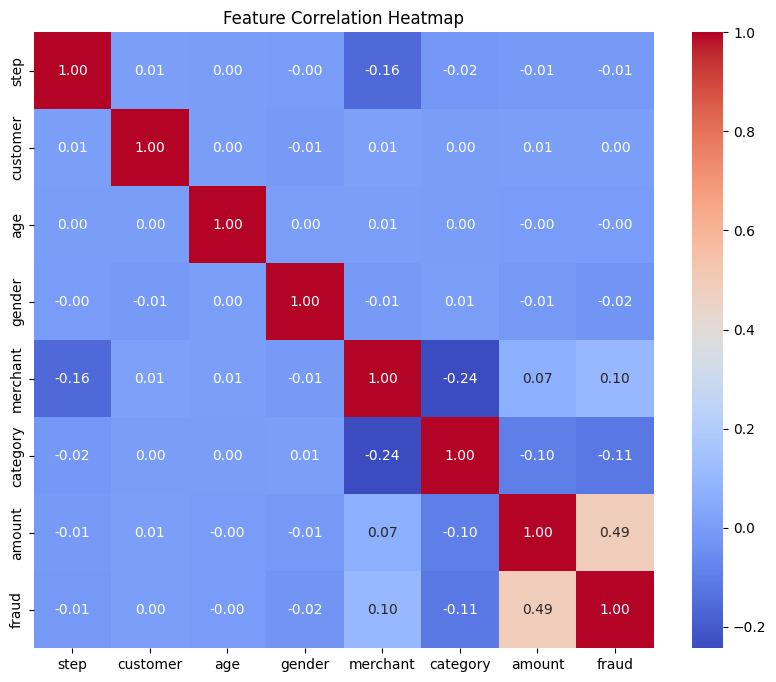

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataset is in a DataFrame called `df`
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

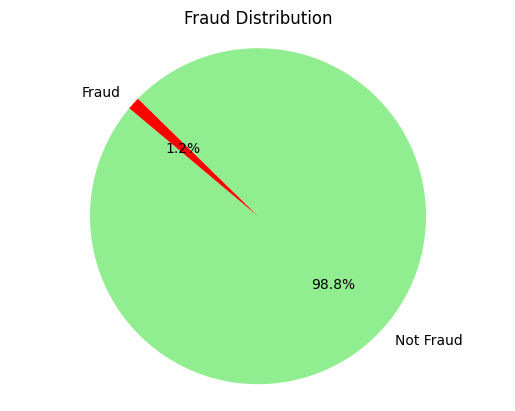

In [88]:
fraud_counts = df['fraud'].value_counts()
labels = ['Not Fraud', 'Fraud']

plt.pie(fraud_counts, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'red'], startangle=140)
plt.title("Fraud Distribution")
plt.axis('equal')  # Circle
plt.show()


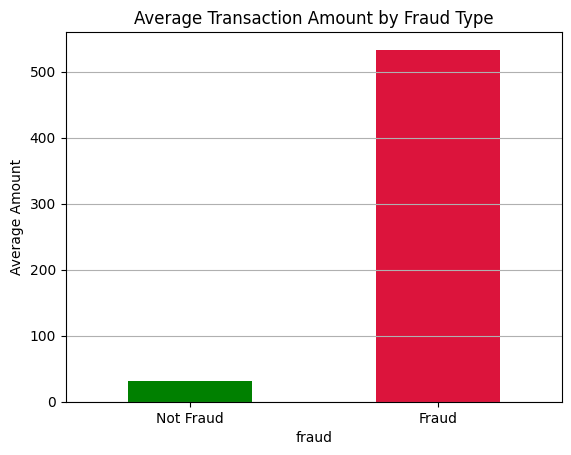

In [89]:
df.groupby('fraud')['amount'].mean().plot(kind='bar', color=['green', 'crimson'])
plt.title("Average Transaction Amount by Fraud Type")
plt.ylabel("Average Amount")
plt.xticks([0, 1], ['Not Fraud', 'Fraud'], rotation=0)
plt.grid(axis='y')
plt.show()

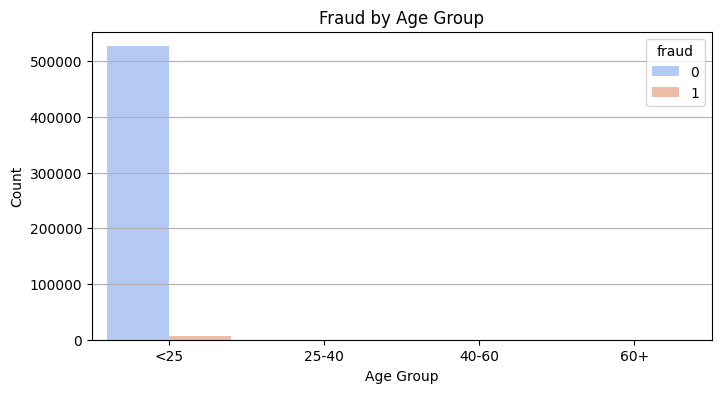

In [91]:
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 40, 60, 100], labels=['<25', '25-40', '40-60', '60+'])

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='age_group', hue='fraud', palette='coolwarm')
plt.title("Fraud by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()